# Feature Selection and Parameter Tuning in Classification

This notebook evaluates the performance of Logistic Regression and Decision Tree models on a classification task, focusing on overall accuracy and class performance. The goal is to predict student outcomes based on their features.

Grid search is performed on both models to optimise parameters and improve accuracy. In the Decision Tree model, this process indirectly performs feature selection by discarding less important features. In Logistic Regression, increasing L1 regularisation strength achieves a similar effect by shrinking coefficients to zero, effectively removing less relevant features.

Feature importance varies across machine learning algorithms. While both models show some agreement on the most and least important features, their rankings differ significantly in some cases.

Moreover, feature importance is not stable across multiple iterations. While certain top and bottom features remain consistently important, many others exhibit high variability. This instability is likely due to the small dataset size, high number of features, and randomness introduced during data splitting.

Author: Hilton Lam (2024)

## Load and discover the data

In [3]:
# Import the necessary packages 

import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, recall_score

from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('Student_Perf.csv') # Read the data file
df.drop(columns=df.columns[0], axis=1, inplace=True) # remove the column of original index as this is not a useful feature
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,reason,guardian,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,outcome
0,0.0,0.0,18,1.0,0.0,0.0,4.0,4.0,0.0,1.0,...,0.0,0.0,3.0,2.0,3.0,0.0,0.0,2.0,4.0,Low
1,0.0,0.0,17,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,4.0,2.0,2.0,0.0,0.0,2.0,2.0,Low
2,0.0,0.0,15,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,0.0,3.0,2.0,1.0,1.0,2.0,2.0,6.0,Low
3,0.0,0.0,15,1.0,0.0,1.0,4.0,2.0,1.0,1.0,...,1.0,1.0,2.0,1.0,1.0,0.0,0.0,4.0,0.0,High
4,0.0,0.0,16,1.0,0.0,1.0,3.0,3.0,1.0,0.0,...,0.0,0.0,3.0,2.0,1.0,0.0,1.0,4.0,0.0,High


In [5]:
# To understand the features of the data set
df.describe()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,reason,guardian,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,...,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,0.348228,0.409861,16.744222,0.696456,0.295840,0.876733,2.514638,2.306626,1.112481,0.827427,...,0.893683,0.767334,0.368259,2.930663,2.180277,2.184900,0.502311,1.280431,2.536210,3.596302
std,0.476776,0.492187,1.218138,0.460143,0.456771,0.328996,1.134552,1.099931,1.192045,0.519187,...,0.308481,0.422857,0.482704,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.364954
min,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,16.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,3.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,17.000000,1.000000,0.000000,1.000000,2.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,3.000000,2.000000,2.000000,0.000000,1.000000,3.000000,2.000000
75%,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,4.000000,3.000000,2.000000,1.000000,...,1.000000,1.000000,1.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,6.000000
max,1.000000,1.000000,22.000000,1.000000,1.000000,1.000000,4.000000,4.000000,3.000000,2.000000,...,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,23.000000


In [6]:
# to understand the datatypes and null count in the df 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      649 non-null    float64
 1   sex         649 non-null    float64
 2   age         649 non-null    int64  
 3   address     649 non-null    float64
 4   famsize     649 non-null    float64
 5   Pstatus     649 non-null    float64
 6   Medu        649 non-null    float64
 7   Fedu        649 non-null    float64
 8   reason      649 non-null    float64
 9   guardian    649 non-null    float64
 10  traveltime  649 non-null    float64
 11  studytime   649 non-null    float64
 12  failures    649 non-null    float64
 13  schoolsup   649 non-null    float64
 14  famsup      649 non-null    float64
 15  paid        649 non-null    float64
 16  activities  649 non-null    float64
 17  nursery     649 non-null    float64
 18  higher      649 non-null    float64
 19  internet    649 non-null    f

This shows that the dataset has no null value and is all numeric.

In [8]:
# What are the outcomes there?
df['outcome'].unique()

array(['Low', 'High'], dtype=object)

## Task 1 - Model Accuracy

In [10]:
y = df.pop('outcome').values # column to predict
Xraw = df.values 

# Normalise the data
scaler = StandardScaler() 
X = scaler.fit_transform(Xraw)

In [11]:
# Set the default parameters for the classifiers
LR = LogisticRegression(random_state=0)
dtree = DecisionTreeClassifier(criterion='entropy')
models = [dtree,LR]

5 x CV DecisionTreeClassifier 

              precision    recall  f1-score   support

        High       0.58      0.62      0.60       276
         Low       0.70      0.67      0.69       373

    accuracy                           0.65       649
   macro avg       0.64      0.64      0.64       649
weighted avg       0.65      0.65      0.65       649

5 x CV LogisticRegression     

              precision    recall  f1-score   support

        High       0.67      0.71      0.69       276
         Low       0.77      0.75      0.76       373

    accuracy                           0.73       649
   macro avg       0.72      0.73      0.72       649
weighted avg       0.73      0.73      0.73       649



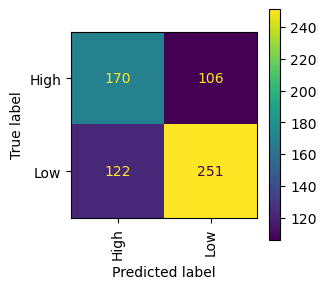

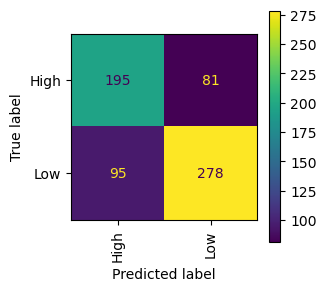

In [12]:
folds = 5  # 5 fold for cross validation
# Create a cross-validation splitter with a fixed random state
cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

model_accuracies = [] #  to store accuracy scores for the task later

for m in models:
    print("{} x CV {:22} \n".format(folds, type(m).__name__))
    y_pred = cross_val_predict(m, X, y, cv=cv) # Perform cross-validation and get predicted labels
    report = classification_report(y, y_pred)
    print(report) # Print classification report with the aggregate result
    
    # plot the confusion matrix
    fig, ax = plt.subplots(figsize=(3,3)) 
    disp = ConfusionMatrixDisplay.from_predictions(y,y_pred, ax = ax, xticks_rotation = 'vertical')

    # Calculate accuracy
    accuracy = accuracy_score(y, y_pred)
    
    # Store the model name and its accuracy in the list
    model_accuracies.append({
        'Model': type(m).__name__,
        'Accuracy': accuracy
    })

# Putting the accuracy stores in a dataframe
model_accuracies_df = pd.DataFrame(model_accuracies)
# model_accuracies_df

This shows that Logistic Regression has a better accuracy than Decision Tree, as they have accuracy scores of 0.73 and 0.65 respectively.  They are both better at predicting the majority class (Low) as both of them show a better F-1 score for the majority class than the minority class.

### Perform Grid Search on Decision Tree for Parameter Tuning

In [15]:
# Create a cross-validation splitter with a fixed random state
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier())
])

param_grid = {
    # 'classifier__min_samples_split': [2, 5, 10, 20, 25, 30, 35, 40, 50] # Control the min samples per split (round 1)
    'classifier__min_samples_split': [31, 32, 33, 34, 35, 36, 37, 38, 39] # Control the min samples per split (round 2)
    # 'classifier__max_depth': [3, 4, 5, 6, 7], # control the layers of the tree (tried but not as effective)
    # 'classifier__min_samples_leaf': [2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200], # control min number of samples per leaf (tried but not as effective)
}

# Use custom grid search 
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv= cv, 
    scoring='accuracy', # to find the parameters to minimise dtree accuracy
    n_jobs=-1 # for parallel processing
)

grid_search.fit(X, y)

print("Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Use best model
best_dtree = grid_search.best_estimator_

Best parameters:
classifier__min_samples_split: 35


I tried to tune few parameters one at a time to see which one could boost the accuracy of the clasifier the most. Min_samples_split is the clear winner. Then, I started with a wider range of values of min_samples_split (round 1), which returned 35 as the optimal value. I then did another round of grid search with more values close to 35 at a smaller interval. 35 still returned as the best parameter value for min_samples_split, which I will use for the rest of this exercise.

#### Assess the performance of this decision tree with tuned parameter

5 x CV Decision Tree Classifier with Tuned Parameter 

              precision    recall  f1-score   support

        High       0.62      0.62      0.62       276
         Low       0.72      0.72      0.72       373

    accuracy                           0.68       649
   macro avg       0.67      0.67      0.67       649
weighted avg       0.68      0.68      0.68       649



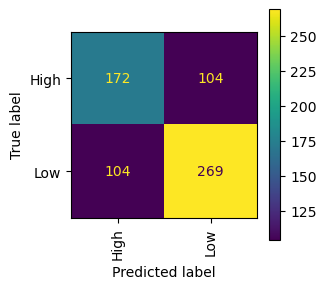

In [18]:
# Create a cross-validation splitter with a fixed random state
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("5 x CV Decision Tree Classifier with Tuned Parameter \n")
y_pred = cross_val_predict(best_dtree, X, y, cv=cv) # Perform cross-validation and get predicted labels
print(classification_report(y, y_pred)) # Print classification report with the aggregate result

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(3,3)) 
disp = ConfusionMatrixDisplay.from_predictions(y,y_pred, ax = ax, xticks_rotation = 'vertical')

In [19]:
# Insert the result in a summary dataframe
accuracy = accuracy_score(y, y_pred)
new_result = pd.Series(['Decision Tree w/ Tuned Parameter', accuracy], index=['Model', 'Accuracy'])

# Concatenate the new row with the existing DataFrame
model_accuracies_df = pd.concat([model_accuracies_df, new_result.to_frame().T], ignore_index=True)
# model_accuracies_df

After tuning the chosen one parameter (min_samples_split), we see a marginal improvement in model accuracy from 0.65 to 0.68. The F1 score for both classes also increased.

It is likely that we can further improve the model if we are allowed to tune multiple parameters simultaneously. For the purpose of this exercise, I will only tune one parameter in the classifier.

### Perform Grid Search on Logistic Regression for L1 Regularisation

In [22]:
# Create a cross-validation splitter with a fixed random state
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('classifier', LogisticRegression(random_state=0,penalty='l1', solver='liblinear')) # Need to use 'liblinear' solver for L1 regularisation
])

param_grid = {
    # 'classifier__C': [0.01, 0.1, 1, 10, 100] # Step 1 in Grid Search identities 1 being the best
    'classifier__C': [0.1, 0.5, 0.7, 0.8, 0.9, 1, 3, 5, 7, 10, 100] # Step 2: search with more numbers close to 1
}

# Use custom grid search 
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv= cv, 
    scoring='accuracy', # to find the parameters to minimise classifier accuracy
    n_jobs=-1 # for parallel processing
)

grid_search.fit(X, y)

print("Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Use best model
best_log_reg = grid_search.best_estimator_

Best parameters:
classifier__C: 0.8


5 x CV Logistic Regression with Best Parameters 

              precision    recall  f1-score   support

        High       0.67      0.72      0.69       276
         Low       0.78      0.74      0.76       373

    accuracy                           0.73       649
   macro avg       0.73      0.73      0.73       649
weighted avg       0.73      0.73      0.73       649



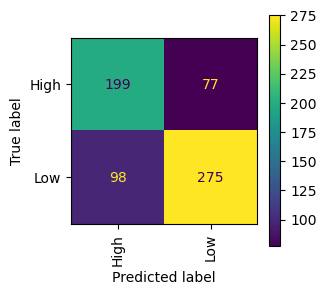

In [23]:
# Create a cross-validation splitter with a fixed random state
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("5 x CV Logistic Regression with Tuned Parameter \n")
y_pred = cross_val_predict(best_log_reg, X, y, cv=cv) # Perform cross-validation and get predicted labels
print(classification_report(y, y_pred)) # Print classification report with the aggregate result

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(3,3)) 
disp = ConfusionMatrixDisplay.from_predictions(y,y_pred, ax = ax, xticks_rotation = 'vertical')

In [24]:
# Insert the result in a summary dataframe
accuracy = accuracy_score(y, y_pred)
new_result = pd.Series(['Logistic Regression Regularised', accuracy], index=['Model', 'Accuracy'])

# Concatenate the new row with the existing DataFrame
model_accuracies_df = pd.concat([model_accuracies_df, new_result.to_frame().T], ignore_index=True)
model_accuracies_df

,Model,Accuracy
0,DecisionTreeClassifier,0.64869
1,LogisticRegression,0.728814
2,Decision Tree w/ Tuned Parameter,0.679507
3,Logistic Regression Regularised,0.730354


The regularised Logistic Regression has seen a tiny bit of improvement in accuracy, but it may not be statistically signifcant.

I first performed a grid search on a wide range of regularisation strength [0.01, 0.1, 1, 10, 100], which showed 1 to be the best in this list. Then I performed a second grid search with parameters close to 1 with a smaller interval [0.1, 0.5, 0.7, 0.8, 0.9, 1, 3, 5, 7, 10, 100] and it has found 0.8 to be the best parameter in the list.

### Display the accuracy of these models in a chart

In [27]:
# Rename the first two rows' labels
model_accuracies_df.loc[0, 'Model'] = 'Decision Tree (Baseline)'
model_accuracies_df.loc[1, 'Model'] = 'Logistic Regression (Baseline)'

# Reorder the data based on the desired order
desired_order = ["Decision Tree (Baseline)", 
                 "Decision Tree w/ Tuned Parameter", 
                 "Logistic Regression (Baseline)", 
                 "Logistic Regression Regularised"]
model_accuracies_df = model_accuracies_df.set_index("Model").loc[desired_order].reset_index()

In [28]:
model_accuracies_df

,Model,Accuracy
0,Decision Tree (Baseline),0.64869
1,Decision Tree w/ Tuned Parameter,0.679507
2,Logistic Regression (Baseline),0.728814
3,Logistic Regression Regularised,0.730354


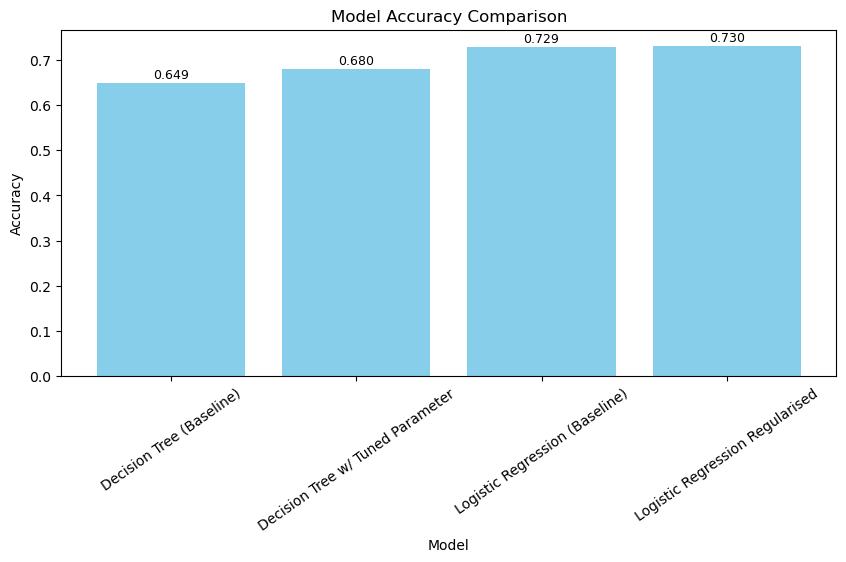

In [29]:
# Create the bar chart
plt.figure(figsize=(10, 4.5))
bars = plt.bar(model_accuracies_df["Model"], model_accuracies_df["Accuracy"], color="skyblue")

# Add data labels
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f"{bar.get_height():.3f}", ha='center', fontsize=9)

plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=35)
plt.show()

We can see that the accuracies for both the decision tree and logistic regression models improved marginally after hyper parameter tuning, with the a greater improvement seen with the decision tree.

## Task 2: Feature Selection


### Feature importance for the tuned decision tree

In [86]:
# Extract the classifier from the pipeline
tree_classifier = best_dtree.named_steps['classifier']

# Get feature importance
importances = tree_classifier.feature_importances_

# Map features to importance values
dtree_feature_importance_df = pd.DataFrame({
    'Feature': df.columns, # Features in the original dataset
    'Importance': importances # Scores from the dtree
}).sort_values(by='Importance', ascending=False)

dtree_feature_importance_df['Dtree_Rank'] = dtree_feature_importance_df['Importance'].rank(ascending=False, method='max') # Add row ranking

print(dtree_feature_importance_df)

       Feature  Importance  Dtree_Rank
12    failures    0.249307         1.0
18      higher    0.110718         2.0
11   studytime    0.077047         3.0
7         Fedu    0.063063         4.0
13   schoolsup    0.056906         5.0
14      famsup    0.053965         6.0
25        Walc    0.045991         7.0
27    absences    0.043342         8.0
2          age    0.043139         9.0
1          sex    0.040889        10.0
0       school    0.039673        11.0
23       goout    0.033856        12.0
26      health    0.033164        13.0
21      famrel    0.030183        14.0
22    freetime    0.029490        15.0
17     nursery    0.018217        16.0
10  traveltime    0.010189        17.0
24        Dalc    0.009301        18.0
8       reason    0.007179        19.0
6         Medu    0.003103        20.0
9     guardian    0.001280        21.0
19    internet    0.000000        28.0
20    romantic    0.000000        28.0
16  activities    0.000000        28.0
15        paid    0.00000

### Feature importance for logistic regression with regularisation

Let's see the feature importance in the logistic regression with the best parameter identified by grid search. 

In [88]:
# Access the logistic regression model within the pipeline with the best parameters found by GridSearch
logistic_model = best_log_reg.named_steps['classifier']
# logistic_model.get_params()

In [90]:
# Get the coefficients
coefficients = logistic_model.coef_[0]

# Map coefficients to feature names
lr_feature_importance = pd.DataFrame({
    'Feature': df.columns, # feature names
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients to show the most impactful features
lr_feature_importance_df = lr_feature_importance.sort_values(by='Coefficient', key = abs, ascending=False) # Key = aboslute so we rank it by absolute value
lr_feature_importance_df['LR_Rank'] = lr_feature_importance_df['Coefficient'].abs().rank(ascending=False, method='max') # Add row ranking

print("Feature Importance by Coefficients:")
print(lr_feature_importance_df)

Feature Importance by Coefficients:
       Feature  Coefficient  LR_Rank
12    failures     0.977200      1.0
18      higher    -0.690437      2.0
27    absences     0.342295      3.0
13   schoolsup     0.335720      4.0
0       school     0.321140      5.0
24        Dalc     0.283783      6.0
26      health     0.261999      7.0
2          age    -0.259751      8.0
1          sex     0.244074      9.0
3      address    -0.204521     10.0
6         Medu    -0.204410     11.0
11   studytime    -0.201278     12.0
7         Fedu    -0.181563     13.0
21      famrel    -0.132579     14.0
5      Pstatus     0.113335     15.0
23       goout     0.109110     16.0
19    internet    -0.108346     17.0
4      famsize     0.105998     18.0
15        paid     0.087420     19.0
20    romantic     0.083955     20.0
16  activities    -0.082075     21.0
25        Walc     0.059889     22.0
9     guardian     0.058235     23.0
17     nursery    -0.043757     24.0
14      famsup     0.036818     25.0
22

No coefficient is 0. This shows that no feature has been deselected by this algorithm. 

For the purpose of visualising feature selection and to see which features will be deselected, I am going to increase the regularisation strength by reducing the C parameter in the logistic regression.

#### Training a new logistic regression model with stronger regularisation

In [92]:
# Hold out testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

# Train a log regression model with stronger regularisation
LR_lowc = LogisticRegression(random_state=0,penalty='l1', solver='liblinear',C=0.1).fit(X_train, y_train) # Set C strength to 0.1 (lowered from 0.8)

# Extract the coefficients
lr_lowc_coefficients = LR_lowc.coef_[0]

# Map coefficients to feature names
lr_lowc_feature_importance = pd.DataFrame({
    'Feature': df.columns, # feature names
    'Coefficient': lr_lowc_coefficients
})

# Sort by absolute value of coefficients to show the most impactful features
lr_lowc_feature_importance_df = lr_lowc_feature_importance.sort_values(by='Coefficient', key = abs, ascending=False) # Key = aboslute so we rank it by absolute value
lr_lowc_feature_importance_df['LR_Rank'] = lr_lowc_feature_importance_df['Coefficient'].abs().rank(ascending=False, method='max') # Add row ranking

print("Feature Importance by Coefficients:")
print(lr_lowc_feature_importance_df)

Feature Importance by Coefficients:
       Feature  Coefficient  LR_Rank
12    failures     0.537755      1.0
18      higher    -0.452254      2.0
6         Medu    -0.321568      3.0
24        Dalc     0.251157      4.0
27    absences     0.171943      5.0
13   schoolsup     0.171266      6.0
26      health     0.157276      7.0
0       school     0.154866      8.0
3      address    -0.134922      9.0
1          sex     0.127930     10.0
21      famrel    -0.121019     11.0
11   studytime    -0.113973     12.0
2          age    -0.084652     13.0
19    internet    -0.074322     14.0
9     guardian     0.027836     15.0
8       reason    -0.025824     16.0
25        Walc     0.011652     17.0
23       goout     0.010395     18.0
20    romantic     0.000000     28.0
22    freetime     0.000000     28.0
4      famsize     0.000000     28.0
17     nursery     0.000000     28.0
16  activities     0.000000     28.0
15        paid     0.000000     28.0
5      Pstatus     0.000000     28.0
7 

In [94]:
# To double check that the model with higher regularisation performs normally
y_pred = LR_lowc.predict(X_test)
print(classification_report(y_test, y_pred)) # Print classification report

              precision    recall  f1-score   support

        High       0.64      0.78      0.70        58
         Low       0.78      0.65      0.71        72

    accuracy                           0.71       130
   macro avg       0.71      0.71      0.71       130
weighted avg       0.72      0.71      0.71       130



This confirms that this model has reasonable and comparable performance in accuracy.

### How do feature importances compare across the 2 algorithms?

In [96]:
# Combine dataframes by feature column
feature_combined_df = dtree_feature_importance_df.set_index('Feature').join(lr_lowc_feature_importance_df.set_index('Feature'))

# Rename columns
feature_combined_df = feature_combined_df.rename(columns={'Coefficient': 'lr_coeff'})
feature_combined_df = feature_combined_df.rename(columns={'Importance': 'dtree_imp'})

# Print the combined dataframe
print(feature_combined_df)

            dtree_imp  Dtree_Rank  lr_coeff  LR_Rank
Feature                                             
failures     0.249307         1.0  0.537755      1.0
higher       0.110718         2.0 -0.452254      2.0
studytime    0.077047         3.0 -0.113973     12.0
Fedu         0.063063         4.0  0.000000     28.0
schoolsup    0.056906         5.0  0.171266      6.0
famsup       0.053965         6.0  0.000000     28.0
Walc         0.045991         7.0  0.011652     17.0
absences     0.043342         8.0  0.171943      5.0
age          0.043139         9.0 -0.084652     13.0
sex          0.040889        10.0  0.127930     10.0
school       0.039673        11.0  0.154866      8.0
goout        0.033856        12.0  0.010395     18.0
health       0.033164        13.0  0.157276      7.0
famrel       0.030183        14.0 -0.121019     11.0
freetime     0.029490        15.0  0.000000     28.0
nursery      0.018217        16.0  0.000000     28.0
traveltime   0.010189        17.0  0.000000   

**What features are not selected by decision tree?**
- internet
- romantic (also deslected by log regression)
- activities (also deslected by log regression)
- paid
- famsize (also deslected by log regression)
- Pstatus (also deslected by log regression)
- address

**What features are not selected by logistic regression?**
- Fedu
- famsup
- freetime
- nursery
- traveltime
- romantic
- activities
- paid
- famsize
- Pstatus

**Do the 2 algorithms agree on feature importance?**

While there is some agreement between the 2 algorithms (4 out of 7 features deselected by decision tree are also deselected by logistic regression), there is still a considerable amount disagreement in feature importance.

Both algorithms agree on the first 2 features as their most important features - *failures and higher*. There are other features which rank at about the same level, such as *schoolsup, sex and famrel.*

However, there are many other features that rank significantly differently in each algorithm. The best example is famsup, which ranks 6th in the decision tree algorithm but is entirely dropped by logistic regression.

**Therefore, it is fair to conclude that the two algorithms have some agreement on the most and least important features but they also differ considerably when it comes to feature importance on the same dataset.**

### Are the selections stable (consistent across different runs)?

In order to see whether feature selection is shown consistently by our models, I am going to build a loop to run the same model with identical parameters over 10 rounds. In each round, each feature's importance and its rank will be recorded. Then I will plot the rank of each feature in a heatmap to see how the rank changes over each iteration.

Let's start with decision tree.

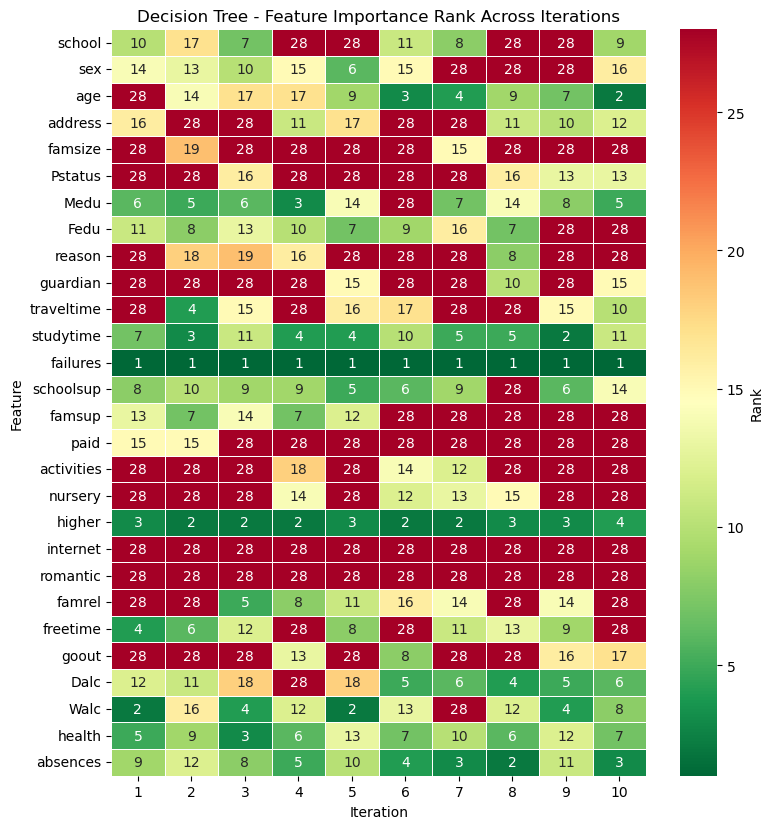

In [99]:
# Number of iterations
num_iterations = 10

# Create a dataframe to store feature's ranks based on importance across iterations
features = df.columns # Feature names
importance_data = pd.DataFrame(index=features, columns=range(1, num_iterations + 1))

for i in range(1, num_iterations + 1):
    # Hold-out testing split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i, test_size=0.2)

    # Train a decision tree model the same parameter as before (best parameter found by gridsearch)
    tuned_dtree = DecisionTreeClassifier(criterion='entropy',min_samples_split= 35).fit(X_train, y_train)

    # Extract the coefficients from the trained model
    dtree_feature_importance_array = tuned_dtree.feature_importances_

    # Map coefficients to feature names and rank them by absolute value
    feature_importance = pd.Series(dtree_feature_importance_array, index=features).abs().rank(ascending=False, method='max') 

    # Save the rankings for this iteration
    importance_data[i] = feature_importance

# Create a heatmap
plt.figure(figsize=(8, len(features) * 0.3))
sns.heatmap(
    importance_data,
    annot=True,  # Show values in cells
    fmt=".0f",  # Format values as integers
    cmap="RdYlGn_r",  # Reverse the blue colormap
    cbar_kws={'label': 'Rank'},
    linewidths=0.5
)
plt.xlabel("Iteration")
plt.ylabel("Feature")
plt.title("Decision Tree - Feature Importance Rank Across Iterations")
plt.tight_layout()
plt.show()

Dark green highlights the most important features and dark red highlights the least important features in the model.

In the heatmap, you can see that for some top and bottom features, the rank of feature importance is largely consistent. For instance, "failures" and "higher" features are often at the top 1-3 spots. "Internet" and "romantic" always rank the lowest.

However, there are also a fair number of inconsistencies, sometimes with significantly different results. "Age" is dropped as a feature in the first iteration but it is ranked rather highly at the second half of the iterations. The same pattern is seen across many other features, such as school, sex, Fedu, famsup, Walc, etc.

Therefore, I conclude that **feature importance is calculated rather inconsistently for this model with this dataset across different runs**. This is likely due to the small set of data (649 rows), a large number of features, and the randomness caused by dataset hold-out splitting.

Now, let's do the same for logistic regression.

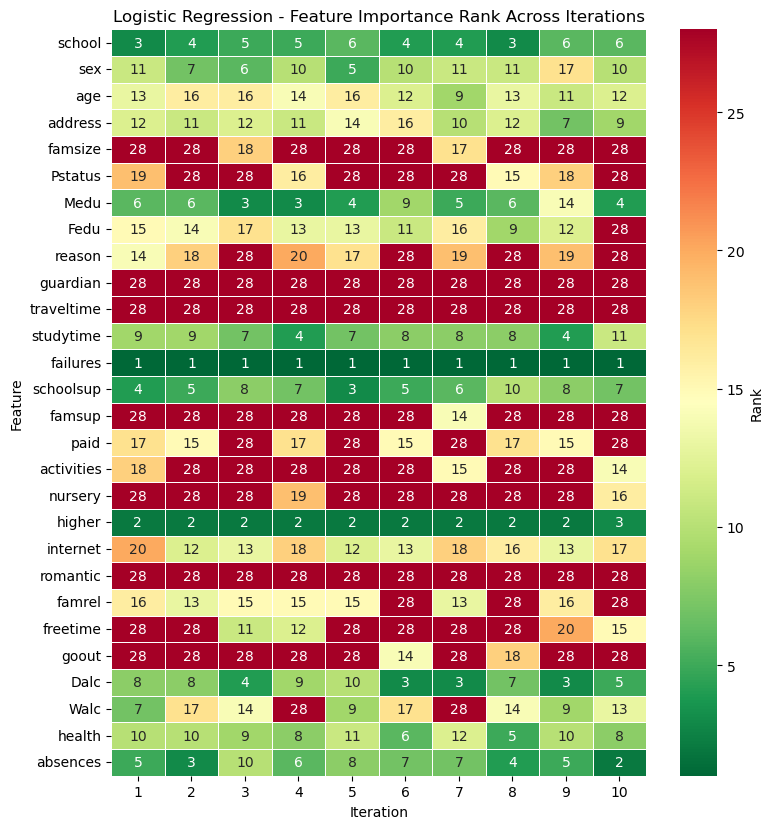

In [101]:
# Number of iterations
num_iterations = 10

# A dataframe to store feature's ranks based on importance across iterations
features = df.columns 
importance_data = pd.DataFrame(index=features, columns=range(1, num_iterations + 1))

for i in range(1, num_iterations + 1):
    # Hold-out testing split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i, test_size=0.2)

    # Train a logistic regression model the same parameter as before
    LR_lowc = LogisticRegression(random_state=i, penalty='l1', solver='liblinear', C=0.1).fit(X_train, y_train)

    # Extract the coefficients from the trained regression model
    lr_lowc_coefficients = LR_lowc.coef_[0]

    # Map coefficients to feature names and rank them by absolute value
    feature_importance = pd.Series(lr_lowc_coefficients, index=features).abs().rank(ascending=False, method='max')

    # Save the rankings for this iteration
    importance_data[i] = feature_importance

# Plotting a heatmap
plt.figure(figsize=(8, len(features) * 0.3))
sns.heatmap(
    importance_data,
    annot=True,  # Show values in cells
    fmt=".0f", 
    cmap="RdYlGn_r",
    cbar_kws={'label': 'Rank'},
    linewidths=0.5
)
plt.xlabel("Iteration")
plt.ylabel("Feature")
plt.title("Logistic Regression - Feature Importance Rank Across Iterations")
plt.tight_layout()
plt.show()

The pattern here with logistic regression's feature coefficient seems slightly more consistent than decision tree because the pattern seems less patchy. Each row seems to show a more consistent shade. That being said, that same phenomenon can be observed here as well.

Some top and bottom features are consistently reported across iteractions, such as "failures" and "higher" being the top and "guardian", "traveltime", and "romantic" being the bottom.

However, there are notable inconsistencies with certain features as well, such as "paid" and "Walc".

**Therefore, while feature importance can be consistently computed for some top and bottom features unambiguously, there is still a high degree of instability for the rest of the features.** Again, this is likely caused by the small dataset, high number of features and randomness caused by dataset splitting.